# Imports

In [1]:



import pandas as pd
import numpy as np
import jsonlines
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch_optimizer as optim


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from importlib import reload
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', '{:0.3f}'.format)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.width = 0
import warnings
import torchvision
warnings.filterwarnings('ignore')

from facebook_hateful_memes_detector.utils.globals import set_global, get_global
set_global("cache_dir", "/home/ahemf/cache/cache")
set_global("dataloader_workers", 4)
set_global("use_autocast", True)
set_global("models_dir", "/home/ahemf/cache/")

from facebook_hateful_memes_detector.utils import read_json_lines_into_df, in_notebook, set_device, print_code, my_collate, load_stored_params
get_global("cache_dir")
from facebook_hateful_memes_detector.models import Fasttext1DCNNModel, MultiImageMultiTextAttentionEarlyFusionModel, VilBertVisualBertModel
from facebook_hateful_memes_detector.preprocessing import TextImageDataset, get_datasets, get_image2torchvision_transforms, TextAugment
from facebook_hateful_memes_detector.preprocessing import DefinedRotation, QuadrantCut, ImageAugment, DefinedAffine, DefinedColorJitter, DefinedRandomPerspective
from facebook_hateful_memes_detector.preprocessing import DefinedAffine, HalfSwap, get_image_transforms, get_transforms_for_bbox_methods
from facebook_hateful_memes_detector.training import *
import facebook_hateful_memes_detector
reload(facebook_hateful_memes_detector)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_device(device)


/home/ahemf/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:


def get_preprocess_text():
    char_level = {
        "keyboard": 0.1,
        "char_substitute": 0.4,
        "char_insert": 0.2,
        "char_swap": 0.2,
        "ocr": 0.0,
        "char_delete": 0.1
    }
    char_level = TextAugment([0.1, 0.4, 0.5], char_level)
    word_level = {
        "fasttext": 0.0,
        "glove_twitter": 0.0,
        "glove_wiki": 0.0,
        "word2vec": 0.0,
        "split": 0.2,
        "stopword_insert": 0.0,
        "word_join": 0.2,
        "word_cutout": 0.8,
        "gibberish_insert": 0.0
    }
    word_level = TextAugment([0.1, 0.4, 0.5], word_level)
    sentence_level = {
        "text_rotate": 0.0,
        "sentence_shuffle": 0.0,
        "one_third_cut": 0.3,
        "half_cut": 0.0,
        "part_select": 0.75
    }
    sentence_level = TextAugment([0.75, 0.25], sentence_level)
    gibberish = {
        "gibberish_insert": 0.25,
        "punctuation_insert": 0.75,
    }
    gibberish = TextAugment([0.75, 0.25], gibberish)

    def process(text):
        text = sentence_level(text)
        text = word_level(text)
        text = char_level(text)
        text = gibberish(text)
        return text

    return process


preprocess_text = get_preprocess_text()
transforms_for_bbox_methods = get_transforms_for_bbox_methods()


data = get_datasets(data_dir="../data/", train_text_transform=preprocess_text, train_image_transform=transforms_for_bbox_methods, 
                    test_text_transform=None, test_image_transform=None, 
                    cache_images = True, use_images = True, dev=False, test_dev=True,
                    keep_original_text=False, keep_original_image=False, 
                    keep_processed_image=True, keep_torchvision_image=False,)

# ImageAugment([0.2, 0.5, 0.3])


In [3]:
sgd = torch.optim.SGD
sgd_params = dict(lr=2e-2,
                  momentum=0.9,
                  dampening=0,
                  weight_decay=0,
                  nesterov=False)

rangerQH = optim.RangerQH
rangerQHparams = dict(
    lr=1e-3,
    betas=(0.9, 0.999),
    nus=(.7, 1.0),
    weight_decay=0.0,
    k=6,
    alpha=.5,
    decouple_weight_decay=True,
    eps=1e-8,
)

adam = torch.optim.Adam
adam_params = params = dict(lr=1e-3, weight_decay=1e-7)

adamw = torch.optim.AdamW
adamw_params = dict(lr=1e-4, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-2)

novograd = optim.NovoGrad
novograd_params = dict(
    lr=1e-3,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0,
    grad_averaging=False,
    amsgrad=False,
)

qhadam = optim.QHAdam
qhadam_params = dict(
    lr=1e-3,
    betas=(0.9, 0.999),
    nus=(1.0, 1.0),
    weight_decay=0,
    decouple_weight_decay=False,
    eps=1e-8,
)

radam = optim.RAdam
radam_params = dict(
    lr=1e-3,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0,
)

yogi = optim.Yogi
yogi_params = dict(lr=1e-2,
                   betas=(0.9, 0.999),
                   eps=1e-3,
                   initial_accumulator=1e-6,
                   weight_decay=0)

In [4]:
batch_size=96
epochs = 10
adamw = torch.optim.AdamW
adamw_params = dict(lr=1e-4, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-2)
optimizer_class = adamw
optimizer_params = adamw_params


scheduler_init_fn = get_cosine_schedule_with_warmup()
reg_sched = get_regularizer_scheduler()




# Finetune Configs

In [5]:
lxmert_strategy = {
    "lxmert": {
        "model": {
            "bert": {
                "encoder": {
                    "x_layers": {
                        "lr": optimizer_params["lr"],
                        "finetune": True
                    },
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "pooler": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
            },
            "finetune": False
        }
    }
}

lxmert_strategy = {
    "finetune": True
}




## LXMERT

In [6]:
model_params = dict(
    model_name={"lxmert": dict(dropout=0.2, gaussian_noise=0.01)},
    num_classes=2,
    gaussian_noise=0.01,
    dropout=0.2,
    word_masking_proba=0.2,
    featurizer="pass",
    final_layer_builder=fb_1d_loss_builder,
    internal_dims=768,
    classifier_dims=768,
    n_tokens_in=96,
    n_tokens_out=96,
    n_layers=0,
    attention_drop_proba=0.0,
    loss="focal",
    dice_loss_coef=0.0,
    auc_loss_coef=0.0,
    bbox_swaps=5,
    bbox_copies=5,
    bbox_gaussian_noise=0.05,
    finetune=False)

from facebook_hateful_memes_detector.models.MultiModal.VilBertVisualBert import VilBertVisualBertModel




model_fn = model_builder(VilBertVisualBertModel,
                         model_params,
                         per_param_opts_fn=lxmert_strategy,
                         optimiser_class=optimizer_class,
                         optimiser_params=optimizer_params)



In [7]:
model, optimizer = model_fn()
load_stored_params(model, "lxmert-smclr.pth")
model = model.to(get_device())


LXRT encoder with 9 l_layers, 5 x_layers, and 5 r_layers.
Load LXMERT pre-trained model from /home/ahemf/.pytorch_pretrained_bert/acfabf2c6d3708e226675d880fed09a14878ef2aee577eeefa8e27a6a22d5b3e.5392626539fa4619737ae314ee55e15de3097750e782865c604a83312ea77251

Weights in loaded but not in model:
answer_head.logit_fc.0.bias
answer_head.logit_fc.0.weight
answer_head.logit_fc.2.bias
answer_head.logit_fc.2.weight
answer_head.logit_fc.3.bias
answer_head.logit_fc.3.weight
cls.predictions.bias
cls.predictions.decoder.weight
cls.predictions.transform.LayerNorm.bias
cls.predictions.transform.LayerNorm.weight
cls.predictions.transform.dense.bias
cls.predictions.transform.dense.weight
cls.seq_relationship.bias
cls.seq_relationship.weight
obj_predict_head.decoder_dict.attr.bias
obj_predict_head.decoder_dict.attr.weight
obj_predict_head.decoder_dict.feat.bias
obj_predict_head.decoder_dict.feat.weight
obj_predict_head.decoder_dict.obj.bias
obj_predict_head.decoder_dict.obj.weight
obj_predict_head.tr

Config '/local/home/ahemf/mygit/facebook-hateful-memes/facebook_hateful_memes_detector/utils/faster_rcnn_R_101_C4_attr_caffemaxpool.yaml' has no VERSION. Assuming it to be compatible with latest v2.


N tokens Out =  132 Classifier Dims =  768 Matches embedding_dims:  True
Loading saved model:  lxmert-smclr.pth
Loading saved model:  lxmert-smclr.pth



Autocast =  True Epochs =  12 Divisor = 2 Examples = 4250 Batch Size =  128
Training Samples =  8500 Weighted Sampling =  True Num Batches =  34 Accumulation steps =  2


Modifications for VG in RPN (modeling/proposal_generator/rpn.py):
	Use hidden dim 512 instead fo the same dim as Res4 (1024).

Modifications for VG in RoI heads (modeling/roi_heads/fast_rcnn.py))
	Embedding: 1601 --> 256	Linear: 2304 --> 512	Linear: 512 --> 401

LXMERTFeatureExtractor : Loaded Model...

Epoch =  1 Loss = 0.371718 LR = 0.00002787



Epoch =  2 Loss = 0.302246 LR = 0.00005574



scores =  {'map': '0.3942', 'acc': '0.6265', 'auc': '0.5354'}


Proba       Preds    
         min   max   min max
Labels                      
0      0.416 0.582     0   1
1      0.416 0.549     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.460,"[0.5399401783943176, 0.4600598216056824]",0,0,0.455,"[0.5447534918785095, 0.45524653792381287]",0,1,0.471,"[0.5288599133491516, 0.471140056848526]",0,1
1,0.469,"[0.5305930972099304, 0.4694068431854248]",0,0,0.448,"[0.5524311065673828, 0.4475688934326172]",0,1,0.491,"[0.5087689757347107, 0.4912310838699341]",0,0
2,0.480,"[0.5202121138572693, 0.47978782653808594]",0,0,0.443,"[0.5569459199905396, 0.44305410981178284]",0,0,0.442,"[0.5583286285400391, 0.44167137145996094]",0,1
3,0.537,"[0.4633079469203949, 0.5366920232772827]",1,1,0.474,"[0.5262888669967651, 0.4737110733985901]",0,1,0.461,"[0.5389284491539001, 0.46107158064842224]",0,0
4,0.434,"[0.5661338567733765, 0.43386614322662354]",0,0,0.463,"[0.5368596315383911, 0.4631403386592865]",0,1,0.471,"[0.5294002890586853, 0.4705996811389923]",0,1


Predicted,0,1,Actual Counts,Recall %
Actual,,,,
0,227,23,250.000,90.000
1,221,29,250.000,11.000
Predicted Counts,448,52,500.000,nan
Precision %,50,55,nan,nan


scores =  {'map': '0.5101', 'acc': '0.5120', 'auc': '0.5038'}
Epoch =  2 Train = ['39.42', '62.65', '53.54'] Val = ['51.01', '51.20', '50.38']



Epoch =  3 Loss = 0.261504 LR = 0.00008361



Epoch =  4 Loss = 0.239119 LR = 0.00009941



Epoch =  5 Loss = 0.223741 LR = 0.00009321



scores =  {'map': '0.4295', 'acc': '0.6439', 'auc': '0.5699'}


Proba       Preds    
         min   max   min max
Labels                      
0      0.409 0.558     0   1
1      0.410 0.573     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.446,"[0.5535299777984619, 0.4464700520038605]",0,1,0.466,"[0.5339650511741638, 0.4660349488258362]",0,0,0.458,"[0.5423886775970459, 0.4576113522052765]",0,0
1,0.436,"[0.5640074014663696, 0.43599265813827515]",0,0,0.486,"[0.5139890313148499, 0.4860110282897949]",0,0,0.454,"[0.5462771058082581, 0.45372292399406433]",0,0
2,0.443,"[0.5566583871841431, 0.44334161281585693]",0,1,0.466,"[0.534449577331543, 0.4655504822731018]",0,0,0.452,"[0.548474907875061, 0.45152509212493896]",0,1
3,0.470,"[0.5296117663383484, 0.47038814425468445]",0,0,0.475,"[0.5249975919723511, 0.4750024378299713]",0,1,0.465,"[0.53513103723526, 0.4648689329624176]",0,0
4,0.488,"[0.5119325518608093, 0.4880673885345459]",0,1,0.437,"[0.5628529787063599, 0.43714699149131775]",0,0,0.496,"[0.5036797523498535, 0.49632030725479126]",0,0


Predicted,0,1,Actual Counts,Recall %
Actual,,,,
0,241,9,250.000,96.000
1,241,9,250.000,3.000
Predicted Counts,482,18,500.000,nan
Precision %,50,50,nan,nan


scores =  {'map': '0.5149', 'acc': '0.5000', 'auc': '0.5199'}
Epoch =  5 Train = ['42.95', '64.39', '56.99'] Val = ['51.49', '50.00', '51.99']



Epoch =  6 Loss = 0.217755 LR = 0.00008105



Epoch =  7 Loss = 0.209436 LR = 0.00006461



scores =  {'map': '0.4261', 'acc': '0.6265', 'auc': '0.5698'}


Proba       Preds    
         min   max   min max
Labels                      
0      0.438 0.559     0   1
1      0.435 0.577     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.458,"[0.5417620539665222, 0.4582379460334778]",0,1,0.489,"[0.5114206671714783, 0.4885793626308441]",0,1,0.480,"[0.5203284025192261, 0.47967153787612915]",0,1
1,0.465,"[0.5351174473762512, 0.464882493019104]",0,1,0.480,"[0.5202332139015198, 0.47976675629615784]",0,0,0.480,"[0.5200022459030151, 0.4799976646900177]",0,1
2,0.477,"[0.5233361721038818, 0.4766637682914734]",0,0,0.497,"[0.5025256276130676, 0.4974743127822876]",0,0,0.475,"[0.5249338150024414, 0.4750661551952362]",0,1
3,0.481,"[0.5186935663223267, 0.48130643367767334]",0,0,0.483,"[0.517124593257904, 0.48287543654441833]",0,0,0.480,"[0.5197601318359375, 0.4802398383617401]",0,0
4,0.482,"[0.5182378888130188, 0.481762170791626]",0,1,0.486,"[0.5137248635292053, 0.48627516627311707]",0,1,0.478,"[0.5217022895812988, 0.47829774022102356]",0,0


Predicted,0,1,Actual Counts,Recall %
Actual,,,,
0,211,39,250.000,84.000
1,210,40,250.000,16.000
Predicted Counts,421,79,500.000,nan
Precision %,50,50,nan,nan


scores =  {'map': '0.5084', 'acc': '0.5020', 'auc': '0.5097'}
Epoch =  7 Train = ['42.61', '62.65', '56.98'] Val = ['50.84', '50.20', '50.97']



Epoch =  8 Loss = 0.202130 LR = 0.00004616



Epoch =  9 Loss = 0.205092 LR = 0.00002824



scores =  {'map': '0.4327', 'acc': '0.6367', 'auc': '0.5789'}


Proba       Preds    
         min   max   min max
Labels                      
0      0.438 0.549     0   1
1      0.443 0.563     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.484,"[0.5163570046424866, 0.48364293575286865]",0,0,0.483,"[0.5166329145431519, 0.48336708545684814]",0,1,0.470,"[0.5304334163665771, 0.4695666432380676]",0,0
1,0.492,"[0.5081022381782532, 0.4918977618217468]",0,0,0.482,"[0.518369734287262, 0.4816303253173828]",0,0,0.492,"[0.5084859132766724, 0.49151405692100525]",0,0
2,0.485,"[0.5153015851974487, 0.48469844460487366]",0,1,0.465,"[0.5353173017501831, 0.46468278765678406]",0,0,0.475,"[0.5245686173439026, 0.47543129324913025]",0,1
3,0.477,"[0.5232539176940918, 0.4767460525035858]",0,0,0.501,"[0.4988551139831543, 0.5011448860168457]",1,1,0.470,"[0.530366837978363, 0.4696331024169922]",0,1
4,0.479,"[0.5207934379577637, 0.4792066216468811]",0,1,0.495,"[0.5045490264892578, 0.4954509437084198]",0,0,0.471,"[0.5290404558181763, 0.47095954418182373]",0,1


Predicted,0,1,Actual Counts,Recall %
Actual,,,,
0,227,23,250.000,90.000
1,224,26,250.000,10.000
Predicted Counts,451,49,500.000,nan
Precision %,50,53,nan,nan


scores =  {'map': '0.5203', 'acc': '0.5060', 'auc': '0.5231'}
Epoch =  9 Train = ['43.27', '63.67', '57.89'] Val = ['52.03', '50.60', '52.31']



Epoch =  10 Loss = 0.203257 LR = 0.00001331



Epoch =  11 Loss = 0.199715 LR = 0.00000345



scores =  {'map': '0.4331', 'acc': '0.6193', 'auc': '0.5781'}


Proba       Preds    
         min   max   min max
Labels                      
0      0.445 0.556     0   1
1      0.448 0.569     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.484,"[0.5157542824745178, 0.4842457175254822]",0,0,0.477,"[0.5229603052139282, 0.477039635181427]",0,1,0.477,"[0.5229603052139282, 0.477039635181427]",0,1
1,0.479,"[0.5213894248008728, 0.4786106050014496]",0,0,0.473,"[0.5268757343292236, 0.4731242060661316]",0,0,0.504,"[0.49594974517822266, 0.5040502548217773]",1,0
2,0.477,"[0.5234505534172058, 0.47654950618743896]",0,0,0.486,"[0.5140515565872192, 0.48594844341278076]",0,1,0.475,"[0.5246684551239014, 0.47533151507377625]",0,1
3,0.489,"[0.5112965703010559, 0.4887033998966217]",0,1,0.486,"[0.5142712593078613, 0.48572877049446106]",0,1,0.458,"[0.5417045950889587, 0.4582953453063965]",0,0
4,0.474,"[0.5257782340049744, 0.474221795797348]",0,1,0.479,"[0.5214027166366577, 0.4785973131656647]",0,1,0.494,"[0.5061770081520081, 0.49382296204566956]",0,1


Predicted,0,1,Actual Counts,Recall %
Actual,,,,
0,215,35,250.000,86.000
1,207,43,250.000,17.000
Predicted Counts,422,78,500.000,nan
Precision %,50,55,nan,nan


scores =  {'map': '0.5202', 'acc': '0.5160', 'auc': '0.5147'}
Epoch =  11 Train = ['43.31', '61.93', '57.81'] Val = ['52.02', '51.60', '51.47']



Epoch =  12 Loss = 0.199710 LR = 0.00000000



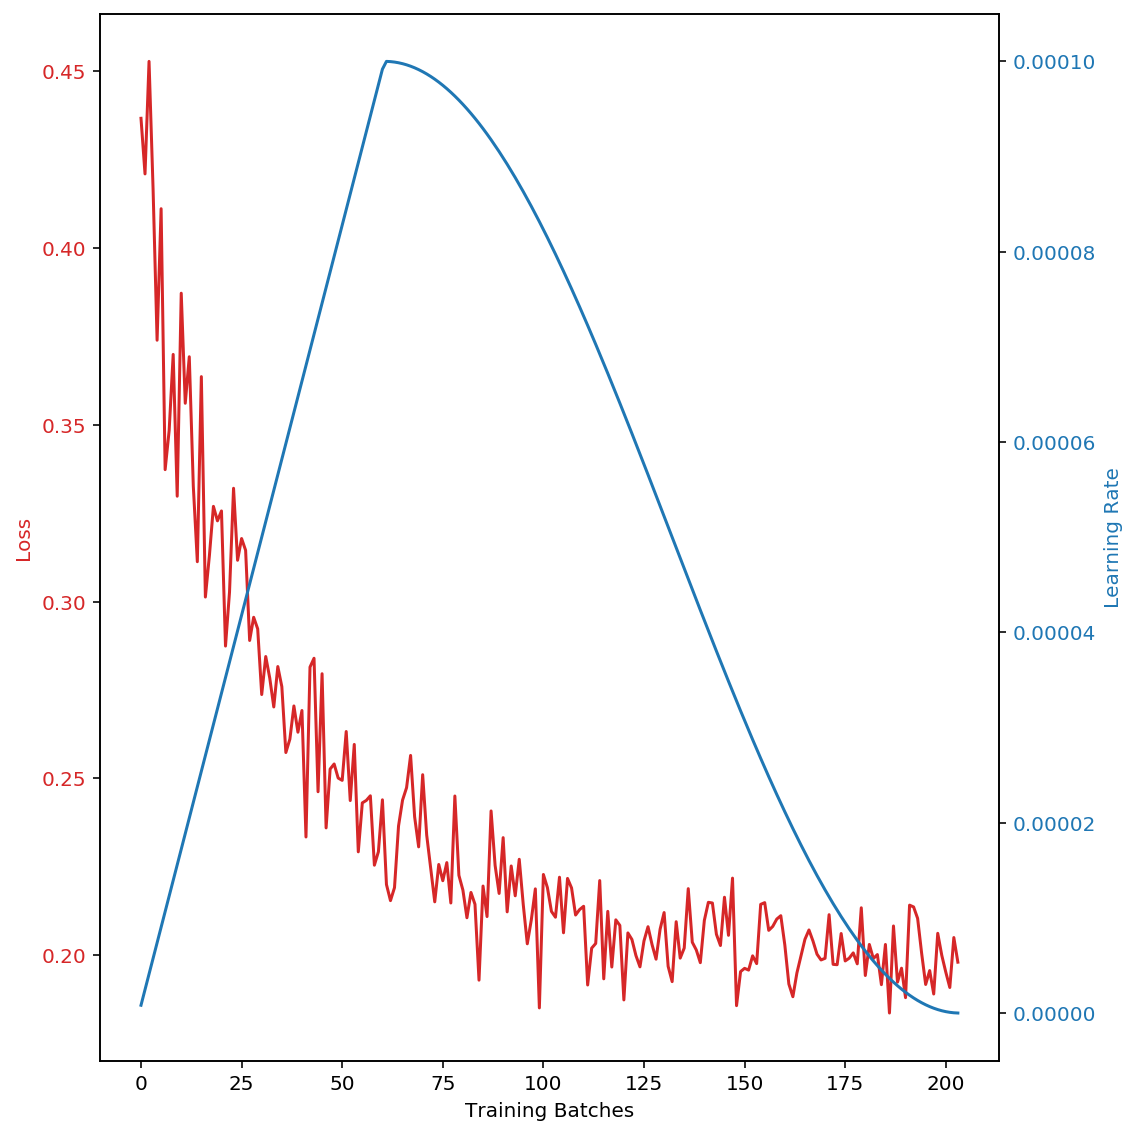

Proba       Preds    
         min   max   min max
Labels                      
0      0.446 0.557     0   1
1      0.449 0.570     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.476,"[0.5244212746620178, 0.47557875514030457]",0,1,0.473,"[0.5265406370162964, 0.4734593629837036]",0,0,0.487,"[0.5131466388702393, 0.48685339093208313]",0,0
1,0.486,"[0.5135872960090637, 0.48641276359558105]",0,0,0.491,"[0.5085052847862244, 0.49149471521377563]",0,1,0.487,"[0.5132575631141663, 0.48674237728118896]",0,0
2,0.487,"[0.5130603313446045, 0.4869396984577179]",0,1,0.482,"[0.5178184509277344, 0.4821816086769104]",0,1,0.469,"[0.531041145324707, 0.46895885467529297]",0,1
3,0.516,"[0.4843517243862152, 0.5156483054161072]",1,0,0.488,"[0.5119857788085938, 0.488014280796051]",0,1,0.489,"[0.5105364918708801, 0.4894634485244751]",0,1
4,0.479,"[0.5210604071617126, 0.47893959283828735]",0,1,0.519,"[0.4814552068710327, 0.5185447931289673]",1,0,0.489,"[0.5112643837928772, 0.4887356162071228]",0,0


Predicted,0,1,Actual Counts,Recall %
Actual,,,,
0,214,36,250.000,85.000
1,206,44,250.000,17.000
Predicted Counts,420,80,500.000,nan
Precision %,50,55,nan,nan


scores =  {'map': '0.5203', 'acc': '0.5160', 'auc': '0.5146'}



scores =  {'map': '0.4333', 'acc': '0.6198', 'auc': '0.5783'}


train   val
mean_or_std metric               
mean        map       0.433 0.520
            accuracy  0.620 0.516
            auc       0.578 0.515
std         map       0.000 0.000
            accuracy  0.000 0.000
            auc       0.000 0.000

train                             val                     
    precision recall    f1  supoort precision recall    f1 supoort
neg     0.665  0.819 0.734 5450.000     0.510  0.856 0.639 250.000
pos     0.449  0.265 0.333 3050.000     0.550  0.176 0.267 250.000

In [8]:
lr_strategy = {
    "finetune": False,
    "model_heads": {
        "finetune": True,
    },
    "final_layer": {
        "finetune": True,
    },
}

_ = group_wise_finetune(model, lr_strategy)
params_conf, _ = group_wise_lr(model, lr_strategy)
optimizer = optimizer_class(params_conf, **optimizer_params)

batch_size=128
epochs = 6

kfold = False
results, prfs = train_validate_ntimes(
    (model, optimizer),
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched,
    validation_epochs=[2, 5, 7, 9, 11, 14, 17, 19, 24, 28],
    show_model_stats=False,
    sampling_policy="without_replacement",
    accumulation_steps=2,
)
r1, p1 = results, prfs
results
prfs


In [ ]:
lr_strategy = {
    "finetune": True
}
adamw = torch.optim.AdamW
adamw_params = dict(lr=5e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-2)
optimizer_class = adamw
optimizer_params = adamw_params

_ = group_wise_finetune(model, lr_strategy)
params_conf, _ = group_wise_lr(model, lr_strategy)
optimizer = optimizer_class(params_conf, **optimizer_params)

batch_size=64
epochs = 16

kfold = False
results, prfs = train_validate_ntimes(
    (model, optimizer),
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched,
    validation_epochs=[5, 7, 9, 11, 15, 17, 24, 28, 31],
    show_model_stats=False,
    sampling_policy="without_replacement",
    accumulation_steps=4,
)
r1, p1 = results, prfs
results
prfs



Autocast =  True Epochs =  32 Divisor = 2 Examples = 4250 Batch Size =  64
Training Samples =  8500 Weighted Sampling =  True Num Batches =  67 Accumulation steps =  4
[WARN]: Number of training batches not divisible by accumulation steps, some training batches will be wasted due to this.



Epoch =  1 Loss = 0.201518 LR = 0.00000521



Epoch =  2 Loss = 0.195962 LR = 0.00001042



Epoch =  3 Loss = 0.193181 LR = 0.00001563



Epoch =  4 Loss = 0.192130 LR = 0.00002084



Epoch =  5 Loss = 0.192135 LR = 0.00002605



scores =  {'map': '0.4617', 'acc': '0.6475', 'auc': '0.6127'}


Proba       Preds    
         min   max   min max
Labels                      
0      0.442 0.519     0   1
1      0.441 0.521     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.456,"[0.5441299080848694, 0.4558701515197754]",0,0,0.442,"[0.5584530234336853, 0.4415470063686371]",0,0,0.464,"[0.5355201363563538, 0.46447989344596863]",0,0
1,0.471,"[0.5292981266975403, 0.47070184350013733]",0,1,0.518,"[0.48210886120796204, 0.5178912281990051]",1,0,0.477,"[0.5227647423744202, 0.4772353172302246]",0,0
2,0.470,"[0.5303419828414917, 0.4696579873561859]",0,1,0.482,"[0.5184355974197388, 0.48156437277793884]",0,1,0.444,"[0.5555202960968018, 0.4444796144962311]",0,1
3,0.478,"[0.5217961072921753, 0.4782038927078247]",0,0,0.475,"[0.5249142646789551, 0.47508567571640015]",0,1,0.487,"[0.5131947994232178, 0.486805260181427]",0,1
4,0.455,"[0.5447326302528381, 0.45526739954948425]",0,1,0.469,"[0.5305500030517578, 0.4694500267505646]",0,0,0.458,"[0.5421974062919617, 0.45780259370803833]",0,0


Predicted,0,1,Actual Counts,Recall %
Actual,,,,
0,245,5,250.000,98.000
1,240,10,250.000,4.000
Predicted Counts,485,15,500.000,nan
Precision %,50,66,nan,nan


scores =  {'map': '0.5337', 'acc': '0.5100', 'auc': '0.5166'}
Epoch =  5 Train = ['46.17', '64.75', '61.27'] Val = ['53.37', '51.00', '51.66']



Epoch =  6 Loss = 0.187859 LR = 0.00003126



Epoch =  7 Loss = 0.185131 LR = 0.00003647



scores =  {'map': '0.4955', 'acc': '0.6498', 'auc': '0.6442'}


Proba       Preds    
         min   max   min max
Labels                      
0      0.431 0.513     0   1
1      0.437 0.521     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.463,"[0.5367056131362915, 0.4632944166660309]",0,0,0.451,"[0.5489470958709717, 0.45105284452438354]",0,1,0.452,"[0.5482656955718994, 0.4517342448234558]",0,0
1,0.459,"[0.5412095785140991, 0.4587903916835785]",0,0,0.459,"[0.5411333441734314, 0.458866685628891]",0,0,0.453,"[0.5466191172599792, 0.45338088274002075]",0,1
2,0.454,"[0.5461074113845825, 0.4538925886154175]",0,1,0.467,"[0.5331431031227112, 0.46685686707496643]",0,1,0.454,"[0.5463379621505737, 0.45366203784942627]",0,1
3,0.449,"[0.5513467788696289, 0.4486532211303711]",0,0,0.469,"[0.5312954783439636, 0.46870461106300354]",0,0,0.471,"[0.5293716788291931, 0.4706282913684845]",0,0
4,0.466,"[0.5341677069664001, 0.46583226323127747]",0,1,0.452,"[0.5479590892791748, 0.4520409107208252]",0,0,0.459,"[0.5413657426834106, 0.45863431692123413]",0,1


Predicted,0,1,Actual Counts,Recall %
Actual,,,,
0,246,4,250.000,98.000
1,243,7,250.000,2.000
Predicted Counts,489,11,500.000,nan
Precision %,50,63,nan,nan


scores =  {'map': '0.5404', 'acc': '0.5060', 'auc': '0.5436'}
Epoch =  7 Train = ['49.55', '64.98', '64.42'] Val = ['54.04', '50.60', '54.36']



Epoch =  8 Loss = 0.185784 LR = 0.00004168



Epoch =  9 Loss = 0.181761 LR = 0.00004689



scores =  {'map': '0.5391', 'acc': '0.6655', 'auc': '0.6625'}


Proba       Preds    
         min   max   min max
Labels                      
0      0.428 0.507     0   1
1      0.434 0.538     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.454,"[0.5461233258247375, 0.45387670397758484]",0,1,0.453,"[0.5466300249099731, 0.45337000489234924]",0,0,0.487,"[0.513468861579895, 0.4865310788154602]",0,1
1,0.479,"[0.5213773250579834, 0.478622704744339]",0,0,0.438,"[0.5618037581443787, 0.43819621205329895]",0,1,0.466,"[0.5340596437454224, 0.4659403860569]",0,0
2,0.456,"[0.5444495677947998, 0.4555503726005554]",0,0,0.473,"[0.5273036360740662, 0.47269630432128906]",0,0,0.450,"[0.5500357747077942, 0.4499642550945282]",0,0
3,0.435,"[0.5651073455810547, 0.4348926544189453]",0,0,0.455,"[0.5452004671096802, 0.4547995924949646]",0,1,0.471,"[0.5291075706481934, 0.4708924889564514]",0,1
4,0.474,"[0.5264595746994019, 0.4735404849052429]",0,0,0.493,"[0.5068779587745667, 0.4931221008300781]",0,1,0.470,"[0.5302746295928955, 0.46972543001174927]",0,0


Predicted,0,1,Actual Counts,Recall %
Actual,,,,
0,247,3,250.000,98.000
1,243,7,250.000,2.000
Predicted Counts,490,10,500.000,nan
Precision %,50,70,nan,nan


scores =  {'map': '0.5591', 'acc': '0.5080', 'auc': '0.5464'}
Epoch =  9 Train = ['53.91', '66.55', '66.25'] Val = ['55.91', '50.80', '54.64']



Epoch =  10 Loss = 0.185052 LR = 0.00004996



Epoch =  11 Loss = 0.182940 LR = 0.00004952



scores =  {'map': '0.5636', 'acc': '0.6844', 'auc': '0.6882'}


Proba       Preds    
         min   max   min max
Labels                      
0      0.436 0.557     0   1
1      0.440 0.570     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.458,"[0.5417090654373169, 0.4582909345626831]",0,0,0.566,"[0.43357759714126587, 0.5664224028587341]",1,1,0.475,"[0.525307834148407, 0.47469213604927063]",0,0
1,0.460,"[0.5402730703353882, 0.4597269594669342]",0,1,0.531,"[0.4693801999092102, 0.5306198000907898]",1,0,0.511,"[0.48938605189323425, 0.5106139779090881]",1,1
2,0.470,"[0.5303024053573608, 0.4696975648403168]",0,0,0.489,"[0.5112646222114563, 0.4887353777885437]",0,0,0.464,"[0.5356180667877197, 0.4643819332122803]",0,0
3,0.470,"[0.5300255417823792, 0.46997442841529846]",0,1,0.467,"[0.5329727530479431, 0.4670272767543793]",0,1,0.509,"[0.491183340549469, 0.508816659450531]",1,0
4,0.472,"[0.528399646282196, 0.4716002643108368]",0,0,0.458,"[0.5424759984016418, 0.45752400159835815]",0,0,0.493,"[0.5070453882217407, 0.4929545223712921]",0,1


Predicted,0,1,Actual Counts,Recall %
Actual,,,,
0,225,25,250.000,90.000
1,208,42,250.000,16.000
Predicted Counts,433,67,500.000,nan
Precision %,51,62,nan,nan


scores =  {'map': '0.5711', 'acc': '0.5340', 'auc': '0.5680'}
Epoch =  11 Train = ['56.36', '68.44', '68.82'] Val = ['57.11', '53.40', '56.80']



Epoch =  12 Loss = 0.178073 LR = 0.00004859


Exception for:  keyboard | ' ' ' ' | ['char_insert' 'keyboard'] argument of type 'NoneType' is not iterable

Epoch =  13 Loss = 0.175202 LR = 0.00004721


# Predict

In [6]:
adam = torch.optim.Adam
adam_params = params = dict(lr=1e-4, weight_decay=1e-2)
optimizer = adam
optimizer_params = adam_params

model_fn = model_builder(VilBertVisualBertModel,
                         dict(model_name={
                             "lxmert":
                             dict(finetune=True,
                                  dropout=0.1,
                                  gaussian_noise=0.2),
                            },
                              num_classes=2,
                              gaussian_noise=0.2,
                              dropout=0.25,
                              featurizer="pass",
                              final_layer_builder=fb_1d_loss_builder,
                              internal_dims=768,
                              classifier_dims=768,
                              n_tokens_in=96,
                              n_tokens_out=96,
                              n_layers=2,
                              loss="focal",
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.0,
                              word_masking_proba=0.2),
                         per_param_opts_fn=combo_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

# model, opt = model_fn()
# model

##
## MMBT Region, Per module regularization, word_masking_proba, reg_scheduling

## Next accumulation_steps


Overriding option config to projects/hateful_memes/configs/vilbert/from_cc.yaml
Overriding option model to vilbert
Overriding option datasets to hateful_memes
Overriding option run_type to val
Overriding option checkpoint.resume_zoo to vilbert.finetuned.hateful_memes.from_cc_original
Overriding option evaluation.predict to true


Some weights of the model checkpoint at bert-base-uncased were not used when initializing ViLBERTBase: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing ViLBERTBase from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing ViLBERTBase from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViLBERTBase were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.v_embeddings.image_embeddings.weight', 'bert.v_embeddings.image_embeddings.bias', 'bert.v_embeddings.image_location_embeddings.weight', 'bert.v_embeddings.image_location_embeddings.bias', 'bert.v_embeddings.LayerNorm.weight', 'bert.v_embeddings.LayerNorm.

Overriding option config to projects/hateful_memes/configs/visual_bert/from_coco.yaml
Overriding option model to visual_bert
Overriding option datasets to hateful_memes
Overriding option run_type to val
Overriding option checkpoint.resume_zoo to visual_bert.finetuned.hateful_memes.from_coco
Overriding option evaluation.predict to true


Some weights of VisualBERTBase were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.embeddings.token_type_embeddings_visual.weight', 'bert.embeddings.position_embeddings_visual.weight', 'bert.embeddings.projection.weight', 'bert.embeddings.projection.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LXRT encoder with 9 l_layers, 5 x_layers, and 5 r_layers.
Load LXMERT pre-trained model from /home/ahemf/.pytorch_pretrained_bert/acfabf2c6d3708e226675d880fed09a14878ef2aee577eeefa8e27a6a22d5b3e.5392626539fa4619737ae314ee55e15de3097750e782865c604a83312ea77251

Weights in loaded but not in model:
answer_head.logit_fc.0.bias
answer_head.logit_fc.0.weight
answer_head.logit_fc.2.bias
answer_head.logit_fc.2.weight
answer_head.logit_fc.3.bias
answer_head.logit_fc.3.weight
cls.predictions.bias
cls.predictions.decoder.weight
cls.predictions.transform.LayerNorm.bias
cls.predictions.transform.LayerNorm.weight
cls.predictions.transform.dense.bias
cls.predictions.transform.dense.weight
cls.seq_relationship.bias
cls.seq_relationship.weight
obj_predict_head.decoder_dict.attr.bias
obj_predict_head.decoder_dict.attr.weight
obj_predict_head.decoder_dict.feat.bias
obj_predict_head.decoder_dict.feat.weight
obj_predict_head.decoder_dict.obj.bias
obj_predict_head.decoder_dict.obj.weight
obj_predict_head.tr

Config '/local/home/ahemf/mygit/facebook-hateful-memes/facebook_hateful_memes_detector/utils/faster_rcnn_R_101_C4_attr_caffemaxpool.yaml' has no VERSION. Assuming it to be compatible with latest v2.
Config '/local/home/ahemf/mygit/facebook-hateful-memes/facebook_hateful_memes_detector/utils/faster_rcnn_R_101_C4_attr_caffemaxpool.yaml' has no VERSION. Assuming it to be compatible with latest v2.


N tokens Out =  722
Autocast =  True Epochs =  14 Divisor = 2 Examples = 4500 Batch Size =  4
Training Samples =  9000 Weighted Sampling =  True Num Batches =  1125 Accumulation steps =  16
[WARN]: Number of training batches not divisible by accumulation steps, some training batches will be wasted due to this.


FeatureExtractor : Loaded Model...
LXMERTFeatureExtractor : Loaded Model...

Epoch =  1 Loss = 0.229189 LR = 0.00023810


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Epoch =  4 Loss = 0.140130 LR = 0.00095238


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Epoch =  7 Loss = 0.154248 LR = 0.00081174



Epoch =  8 Loss = 0.157731 LR = 0.00067268



Epoch =  9 Loss = 0.158405 LR = 0.00051603



Epoch =  10 Loss = 0.153493 LR = 0.00035774



Epoch =  11 Loss = 0.152576 LR = 0.00021394



Epoch =  12 Loss = 0.153589 LR = 0.00009929



Epoch =  13 Loss = 0.147211 LR = 0.00002547



Epoch =  14 Loss = 0.145344 LR = 0.00000000



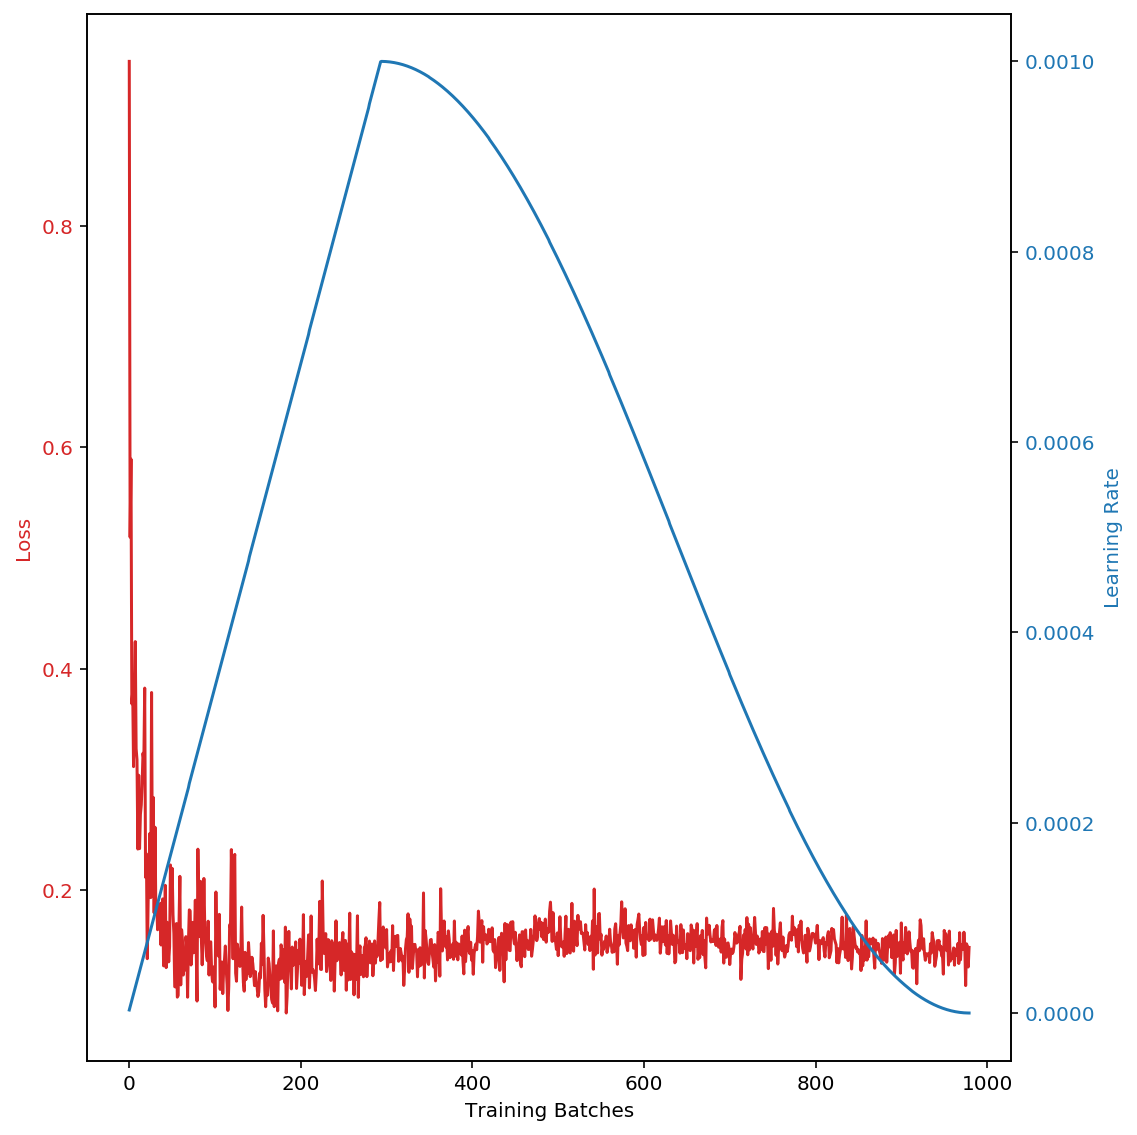

,id,proba,label
655,84517,0.511,1
433,71063,0.671,1
414,85042,0.613,1


In [7]:

torch.backends.cudnn.enabled = False
batch_size = 4
epochs = 7

submission, text_model = train_and_predict(
    model_fn,
    data,
    batch_size,
    epochs,
    scheduler_init_fn=scheduler_init_fn,
    accumulation_steps=16,
    model_call_back=reg_sched,
    sampling_policy="without_replacement") # "without_replacement"

submission.to_csv("submission.csv", index=False)
submission.sample(3)


In [8]:
data["test"] = data["dev"]
sf, _ = predict(text_model, data, batch_size)

print(sf.head())

from sklearn.metrics import roc_auc_score, average_precision_score, classification_report
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

labels_list = data["test"].label
proba_list = sf.proba
predictions_list = sf.label

auc = roc_auc_score(labels_list, proba_list)
# p_micro, r_micro, f1_micro, _ = precision_recall_fscore_support(labels_list, predictions_list, average="micro")
prfs = precision_recall_fscore_support(labels_list, predictions_list, average=None, labels=[0, 1])
map = average_precision_score(labels_list, proba_list)
acc = accuracy_score(labels_list, predictions_list)
validation_scores = [map, acc, auc]
print("scores = ", dict(zip(["map", "acc", "auc"], ["%.4f" % v for v in validation_scores])))



      id  proba  label
0   8291  0.632      1
1  46971  0.350      0
2   3745  0.543      1
3  83745  0.594      1
4  80243  0.617      1
scores =  {'map': '0.6912', 'acc': '0.6920', 'auc': '0.7407'}


In [ ]:
submission.sample(10)
submission.label.value_counts()

In [ ]:


batch_size = 32
epochs = 7

submission, text_model = train_and_predict(
    model_fn,
    data,
    batch_size,
    epochs,
    scheduler_init_fn=scheduler_init_fn,
    accumulation_steps=1,
    model_call_back=reg_sched,
    sampling_policy=None) # "without_replacement"

submission.to_csv("submission2.csv", index=False)
submission.sample(3)
